<a href="https://colab.research.google.com/github/ChristianFel7/Python-para-Data-Science/blob/main/Spark_trabalhando_com_regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

download da base de dados:
https://cdn3.gnarususercontent.com.br/2277-spark/01/aula01.zip

In [1]:
!pip install findspark

In [2]:
import findspark
findspark.init()

In [76]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

In [5]:
spark

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dados = spark.read.json(
    '/content/drive/MyDrive/Alura/imoveis.json',
    multiLine=False
)
dados

DataFrame[ident: struct<customerID:string,source:string>, listing: struct<address:struct<city:string,location:struct<lat:double,lon:double>,neighborhood:string,zone:string>,features:struct<bathrooms:bigint,bedrooms:bigint,floors:bigint,parkingSpaces:bigint,suites:bigint,totalAreas:string,unitFloor:bigint,unitsOnTheFloor:bigint,usableAreas:string>,prices:struct<price:string,tax:struct<condo:string,iptu:string>>,types:struct<unit:string,usage:string>>]

In [8]:
dados.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [9]:
dados.count()

73615

selecionando as features

In [10]:
dataset = dados\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')

In [11]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [12]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as f

In [13]:
dataset = dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))

In [14]:
dataset\
    .select('usage')\
    .groupBy('usage')\
    .count()\
    .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [15]:
dataset = dataset\
    .select('*')\
    .where('usage=="Residencial"')

In [16]:
dataset\
    .select('usage')\
    .groupBy('usage')\
    .count()\
    .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|Residencial|69596|
+-----------+-----+



In [17]:
dataset\
    .select('unit')\
    .groupBy('unit')\
    .count()\
    .show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [18]:
dataset\
    .select('zone')\
    .groupBy('zone')\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [19]:
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [20]:
dataset = dataset\
    .select('*')\
    .na\
    .fill(0)


In [21]:
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [22]:
dataset = dataset\
    .where(f.col('zone') != '')

Regressão linear

utilizando a bibliotexa  pyspark.ml

In [23]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

variáveis dummy

In [24]:
dataset.groupBy("customerID").pivot('unit').agg(f.lit(1)).na.fill(0).show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [25]:
unit = dataset.groupBy("customerID").pivot('unit').agg(f.lit(1)).na.fill(0)

In [26]:
zone = dataset.groupBy("customerID").pivot('zone').agg(f.lit(1)).na.fill(0)

In [28]:
dataset = dataset\
    .join(unit, 'customerID', how='inner')\
    .join(zone, 'customerID', how='inner')

In [29]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [31]:
dataset = dataset.withColumnRenamed('price', 'label')

In [32]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [34]:
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [35]:
assembler = VectorAssembler(inputCols=X, outputCol='features')
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [36]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [37]:
dataset_prep.show(10, truncate=False)

+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

explorando os dados

In [39]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()

In [40]:
correlacao

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

In [43]:
correlacao = Correlation.corr(dataset_prep, 'features', 'pearson').collect()[0][0]
correlacao

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

In [44]:
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [45]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)
dataframe_correlacao

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


<Axes: >

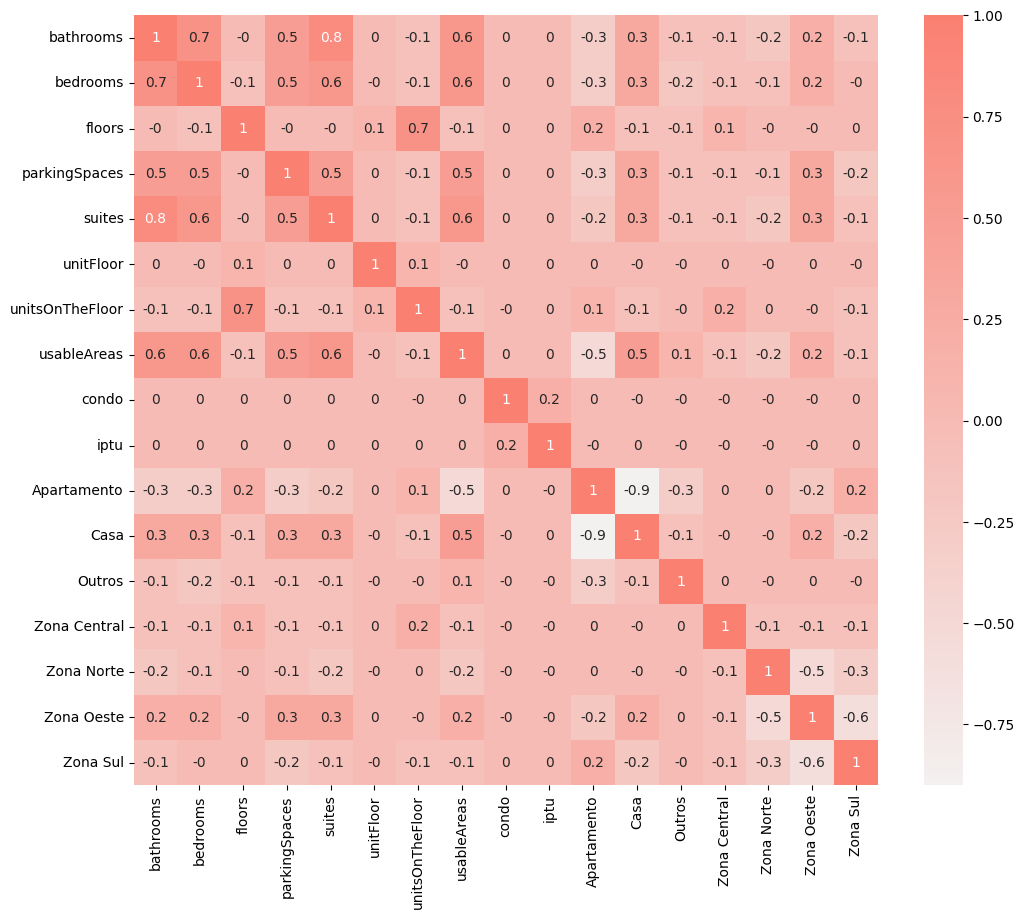

In [48]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap= True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

Ajuste e previsão

In [49]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed = 101)

In [50]:
treino.count()

48528

In [51]:
teste.count()

20911

In [52]:
lr = LinearRegression()

In [53]:
modelo_lr = lr.fit(treino)

In [54]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [55]:
previsoes_lr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|443266.04737020144|
|(17,[0,1,2,3,4,5,...|500000.0|1127455.8300462805|
|(17,[0,1,2,3,4,5,...|308615.0|111210.49949889386|
|(17,[0,1,2,3,4,5,...|279000.0|113587.95787719043|
|(17,[0,1,2,3,4,5,...|545000.0|340703.71307873435|
|(17,[0,1,2,3,4,5,...|449000.0|390571.99595798284|
|(17,[0,1,2,3,4,5,...|479000.0| 444003.4297194885|
|(17,[0,1,2,3,4,5,...|420000.0| 720022.1542161054|
|(17,[0,1,2,3,4,5,...|265000.0|519406.05037395435|
|(17,[0,1,2,3,4,5,...|490000.0| 845483.5388437647|
|(17,[0,1,2,3,4,5,...|650000.0| 644931.4982488954|
|(17,[0,1,2,3,4,5,...|379900.0| 448889.3339027724|
|(17,[0,1,2,3,4,5,...|449000.0| 714548.9501108339|
|(17,[0,1,2,3,4,5,...|190000.0| 411726.9411630478|
|(17,[0,1,2,3,4,5,...|896000.0| 597499.4601552959|
|(17,[0,1,2,3,4,5,...|679000.0| 864544.0129262989|
|(17,[0,1,2,3,4,5,...|620000.0|

Métricas

In [56]:
resumo_treino = modelo_lr.summary

In [57]:
resumo_treino.r2

0.6655873678454578

In [58]:
resumo_treino.rootMeanSquaredError

810348.969531623

In [59]:
resumo_teste = modelo_lr.evaluate(teste)

In [60]:
resumo_teste.r2

0.6585207937774393

In [61]:
resumo_teste.rootMeanSquaredError

800525.9696828632

Tabela resumo da regressão linear

In [62]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.665587
RMSE: 810348.969532

Dados de Teste
R²: 0.658521
RMSE: 800525.969683


# **Árvores de decisão**

Árvore de decisão é um dos modelos de previsão mais simples, inspirada na forma que os seres humanos tomam as decisões e tem uma alta explicabilidade, ou seja, uma compreensão fácil dos passos que foram realizados para conseguir chegar ao resultado final. Essas árvores podem ser utilizadas tanto para modelos de regressão, que têm o objetivo de prever valores numéricos, quanto para modelos de classificação, que têm intuito de prever categorias. Ela pode ser representada graficamente, de forma que cada uma das decisões tomadas no processo possam ser visualizadas. Seus elementos principais são: nós, ramos e folhas.

A estrutura da árvore se inicia com um nó inicial, também chamado de raiz. A partir dela, são traçadas ramificações que geram novos nós. O processo se repete para os nós subsequentes até que chegue a uma folha, que se trata de um nó especial com a informação da resposta. No caso da regressão, a resposta será um valor numérico.

Cada ramo representa uma tomada de decisão a partir de um valor ou categoria das variáveis explicativas, dividindo o conjunto de dados em nós que apresentam dados com características cada vez mais similares entre si.

Critérios de divisão dos nós
Para a escolha da melhor divisão dos dados em cada nó, o algoritmo de árvore de decisão utiliza métricas para mensurar a qualidade da divisão e a escolha da métrica modifica o resultado final obtido pela árvore. Vamos conhecer a métrica que o Spark utiliza como critério para divisão de nós.

Variância
Fórmula matemática de variância igual a 1 dividido por N vezes o somatório de i indo de 1 a N, abre parênteses y_i  menos mi, fecha parênteses ao quadrado.


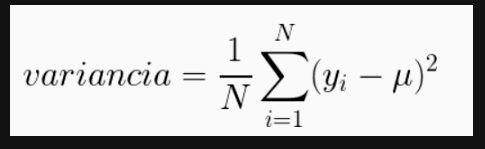

Onde:

y_i: representa o valor real da amostra;

N: representa o número de instâncias; e

Ⲙ: representa a média das amostras.

No momento da divisão de cada um dos nós, o algoritmo faz simulações para a separação dos dados com base em uma variável explicativa e extrai a média da variável alvo em cada um dos nós formados. A partir dessa média, a métrica para avaliação é calculada. A árvore final a ser utilizada pelo modelo será aquela que tiver o melhor resultado em cada uma das simulações.

Vamos compreender melhor os conceitos através de um exemplo.

alt-text: Impressão da árvore de decisão utilizada para regressão com uma sequência de 7 quadrados em três níveis mostrando os critérios de divisão. No primeiro nível há um quadrado com as informações X[0] <= 5.0, var = 16.0, samples=7, value = 6.5. Há dois quadrados no segundo nível, o quadrado do lado esquerdo possui as informações: X[0] <= 1.0, var = 2.667, samples=3, value = =2.5 o quadrado do lado direito possui as informações:  X[0] <= 9.0, var = 5.0, samples = 4, value = 9.5. O último nível são as folhas da árvore e há 4 folhas. Partindo da esquerda para a direita, a primeira contém as informações: var = 0.0, samples = 1, value = 0.5, a segunda: var = 1.0, samples = 2, value = 3.5, a terceira: var = 1.0, samples, value = 7.5 e a quarta: var = 1.0, samples = 2, value = 11.5.



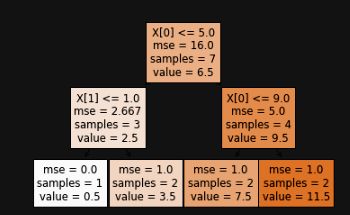




Supondo que nossas variáveis são:

X = [[0, 0], [2, 2], [4, 4], [6, 6], [8, 8], [10, 10],[12, 12]]
y = [0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5]Copiar código
Onde: X é a variável explicativa e y a variável target.

No primeiro nó, o critério de divisão é X[0] <= 5.0 foi escolhido para realizar a primeira divisão que resultou em 3 amostras para o lado esquerdo e 4 amostras para o lado direito. O nó do lado esquerdo tem uma variância de 2.667 e o nó do lado direito tem uma variância de 5.0, resultando em uma variância da primeira divisão de 2.667 + 5.0 = 7.7667. Dentre as simulações feitas para realizar a divisão, essa foi a que trouxe a menor variância e, por isso, foi a escolhida para o modelo final. A construção dos outros nós são análogos a esse primeiro.

Analisando a divisão acima, podemos tirar as seguintes conclusões:

Se a amostra de entrada estiver entre 0 e 1, o modelo prevê o valor 0.5;
Se a amostra de entrada estiver entre 1 e 5, o modelo prevê o valor 3.5;
Se a amostra de entrada estiver for maior que 5 e menor ou igual 9 o modelo prevê o valor 7.5;
Se a amostra de entrada for maior que 9 o modelo prevê o valor 11.5.

In [66]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)
modelo_dtr = dtr.fit(treino)

In [67]:
previsoes_dtr_treino = modelo_dtr.transform(treino)
previsoes_dtr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|308615.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|479000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|265000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|490000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...|650000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...|379900.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|679000.0|1158420.7653661144|
|(17,[0,1,2,3,4,5,...|620000.0|

Métricas

In [68]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.7930752588471226
637436.5434260432


In [69]:
previsoes_dtr_teste = modelo_dtr.transform(teste)
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 350000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...| 340000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 430000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 600000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 439000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 333000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 948000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...| 459600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 447600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 360000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 407000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 310000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|1400000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1180000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1299500.0|1158420.7653661144|
|(17,[0,1,2,

In [70]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.793075
RMSE: 637436.543426

Dados de Teste
R²: 0.773813
RMSE: 651518.489921


# **Random Forest**


O Random Forest baseia-se na utilização de diversas árvores de decisão para encontrar o melhor resultado. Em machine learning, chamamos esse tipo de método de aprendizado de ensemble, em que utilizamos diferentes algoritmos combinados (ou a combinação de um mesmo algoritmo) para obter a predição mais correta.

Dentre os métodos mais comuns de ensemble, existe o chamado bagging (abreviação de bootstrap aggregating), no qual são extraídos subconjuntos dos dados originais, de forma a serem gerados modelos diferentes para cada um desses subconjuntos, causando assim uma diferenciação entre os resultados obtidos por cada um desses modelos.

A amostragem por bootstrap consiste em amostragem por reposição significando que, se sortearmos um elemento, isso não impede o mesmo elemento aparecer em sorteios futuros. Ou seja, uma amostragem com reposição permite ao subconjunto de dados ter amostras repetidas. Dessa forma, os modelos apresentarão resultados diferentes, uma vez que são treinados com diferentes conjuntos de dados.

O Random Forest é um algoritmo do tipo ensemble, utilizando o método de bagging. Para o problema de regressão, o Random Forest segue os seguintes passos:

Internamente, o algoritmo escolhe aleatoriamente amostras a partir do conjunto de treinamento;
Constrói a árvore de decisão associada a esse conjunto de dados;
Repete os passos 1 e 2 para uma quantidade de árvores escolhida pela pessoa cientista de dados; e
Define o resultado da previsão como sendo a média dos resultados obtidos por cada uma das árvores de decisão que foram geradas.
O fluxograma abaixo representa o funcionamento do algoritmo Random Forest de uma forma resumida:

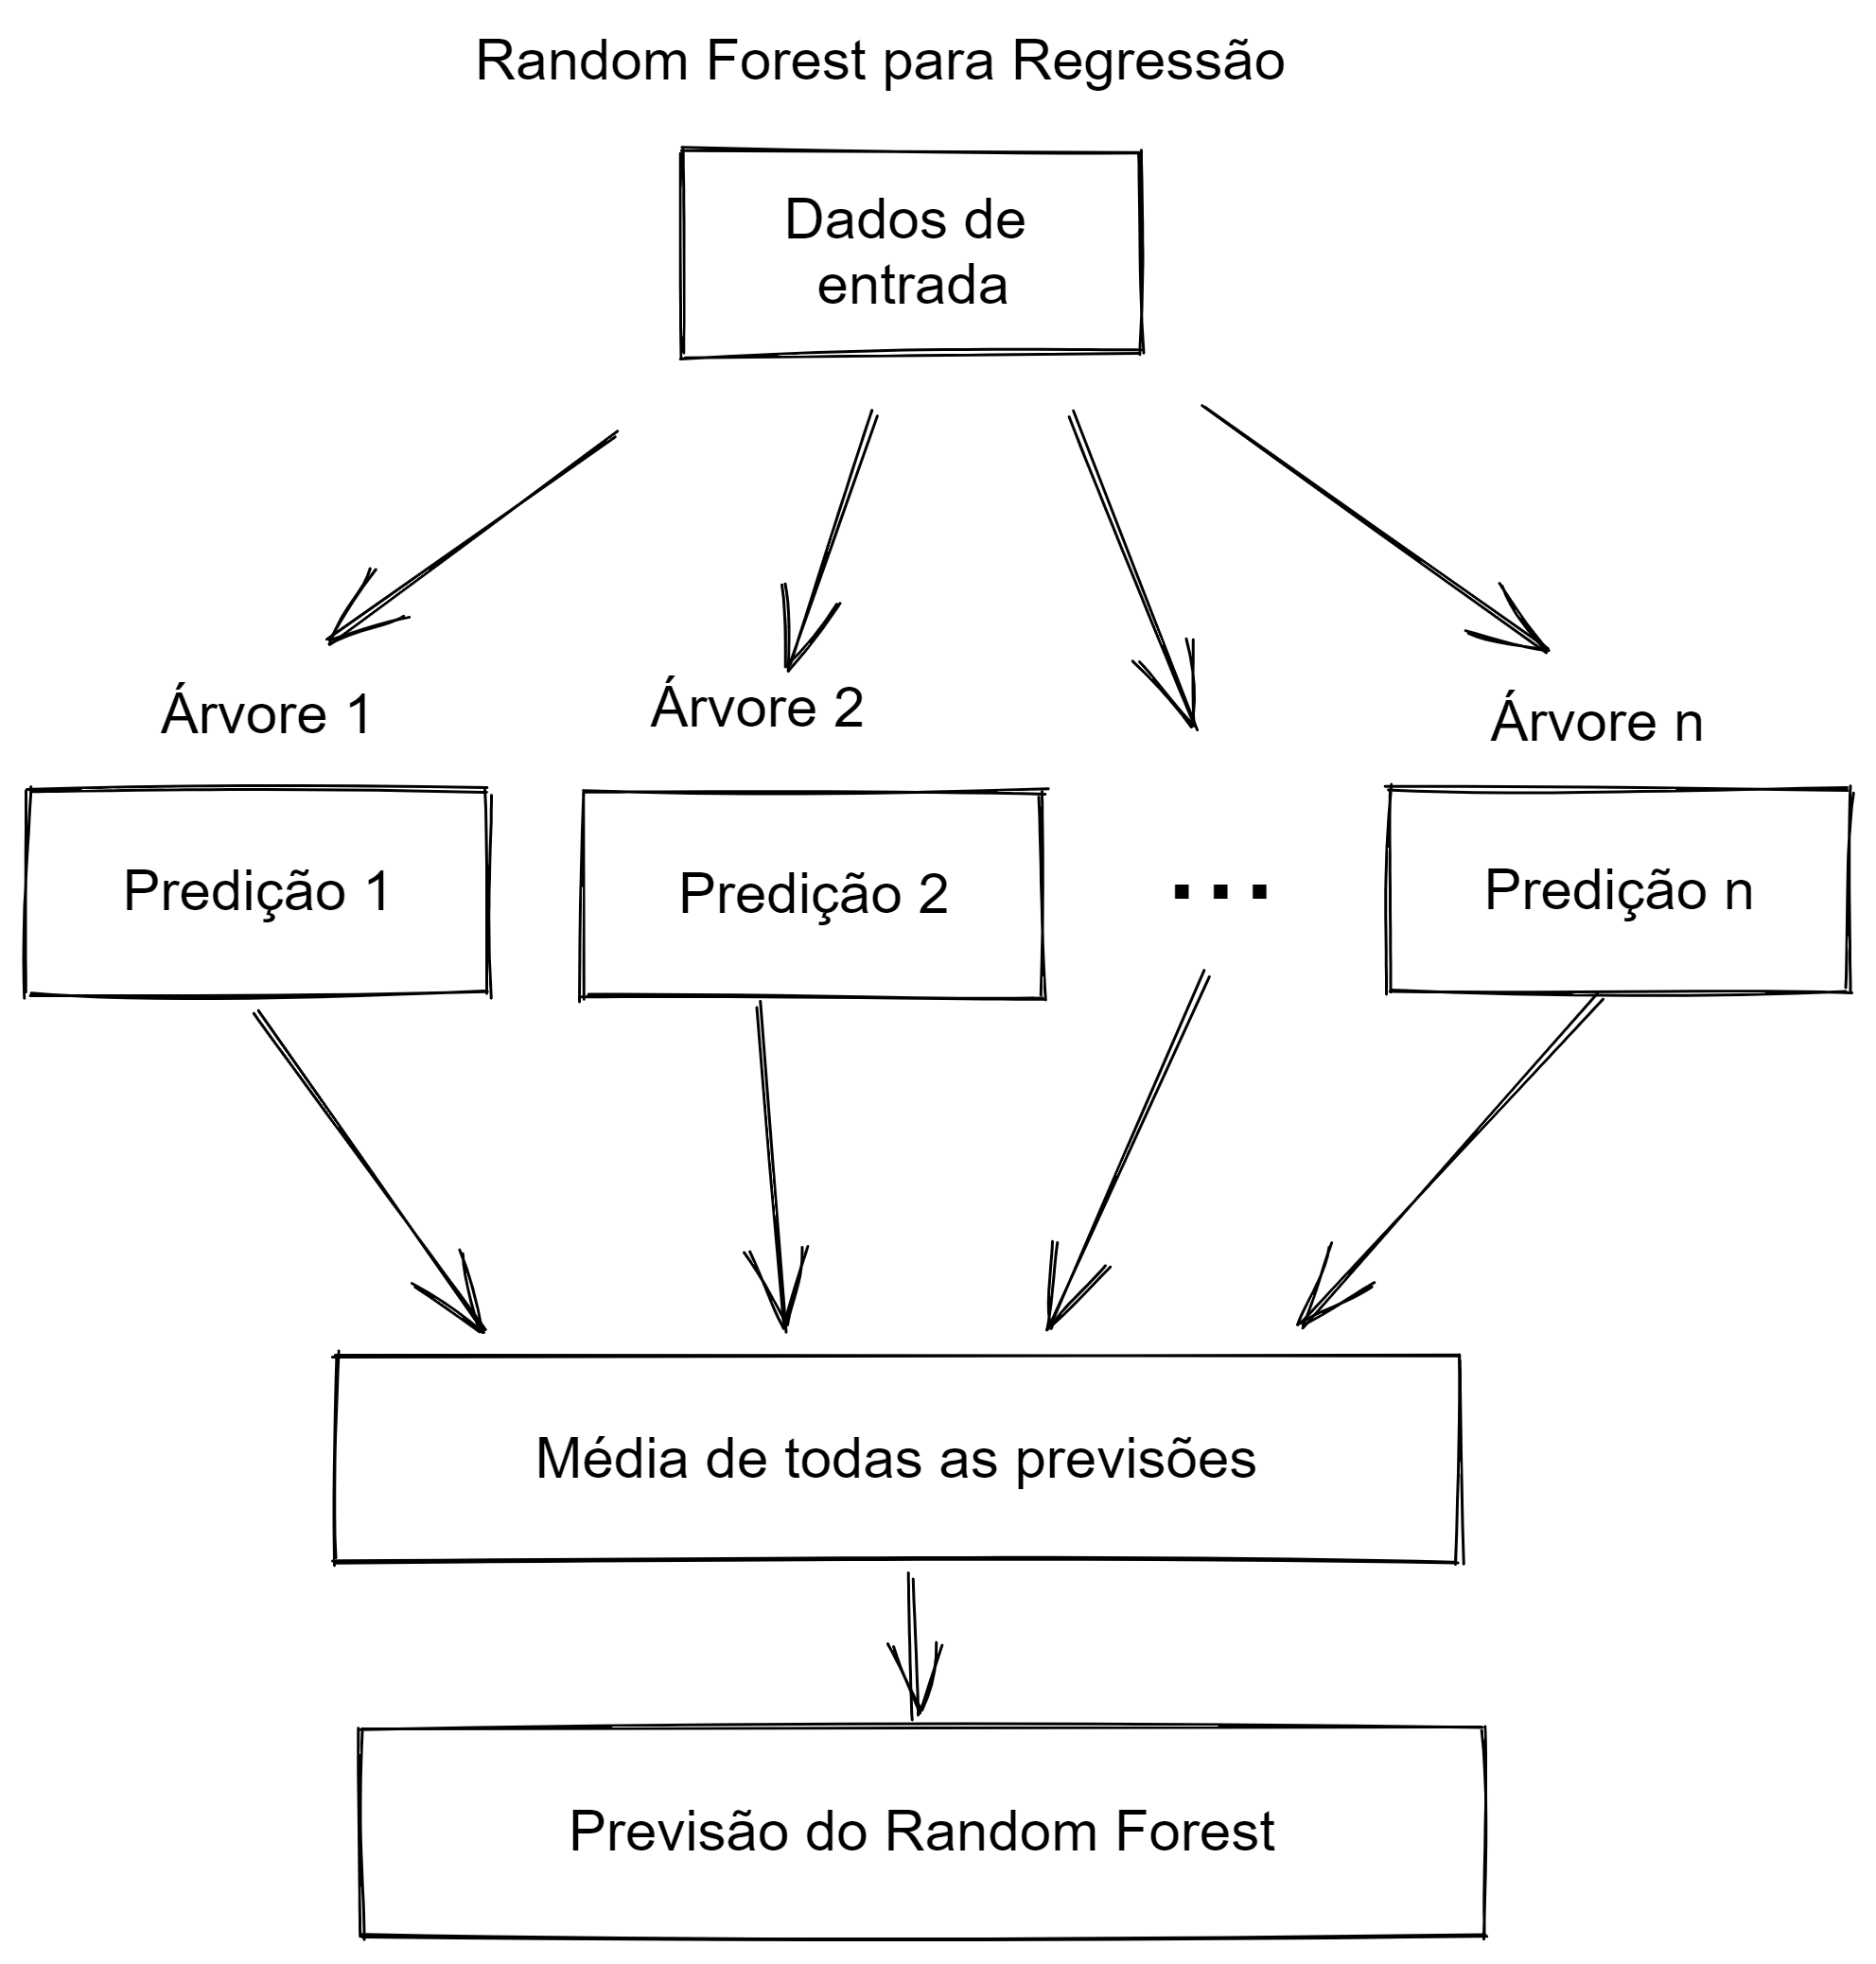

Como vantagens da utilização desse método podemos citar que: mantém uma boa previsão, mesmo que haja dados faltantes; e funciona de forma eficiente, mesmo em conjunto de dados grandes. A principal desvantagem é que, por se tratar de um método ensemble, requer mais recursos computacionais e, devido a isso, necessita de mais tempo para realizar treinamento e previsão.



In [72]:
rfr = RandomForestRegressor(seed=101, maxDepth = 7, numTrees=10)
modelo_rdr = rfr.fit(treino)
previsoes_rfr_treino = modelo_rdr.transform(treino)
previsoes_rfr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|390218.33742322924|
|(17,[0,1,2,3,4,5,...|500000.0| 510060.6595782173|
|(17,[0,1,2,3,4,5,...|308615.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|279000.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|545000.0|  396904.928725379|
|(17,[0,1,2,3,4,5,...|449000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...|479000.0|433807.13396085694|
|(17,[0,1,2,3,4,5,...|420000.0| 664440.4325776277|
|(17,[0,1,2,3,4,5,...|265000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...|490000.0| 816123.0337632223|
|(17,[0,1,2,3,4,5,...|650000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...|379900.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|449000.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|190000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...|896000.0| 547828.3209496561|
|(17,[0,1,2,3,4,5,...|679000.0| 893791.6624292185|
|(17,[0,1,2,3,4,5,...|620000.0|

In [73]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8017561510914318
623922.4426224458


In [74]:
previsoes_rfr_teste = modelo_rdr.transform(teste)
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 350678.0454640939|
|(17,[0,1,2,3,4,5,...| 350000.0| 792518.9735011571|
|(17,[0,1,2,3,4,5,...| 340000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...| 430000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 600000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 439000.0| 550795.8732599718|
|(17,[0,1,2,3,4,5,...| 333000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 948000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...| 459600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 447600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 360000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 407000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...| 310000.0|412580.35636663495|
|(17,[0,1,2,3,4,5,...|1400000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1180000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1299500.0|1111896.8209940076|
|(17,[0,1,2,

In [75]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.801756
RMSE: 623922.442622

Dados de Teste
R²: 0.790530
RMSE: 626981.467738


# **Técnicas de orimização**

No momento da construção dos modelos de machine learning, não podemos utilizar os mesmos dados para treinar e avaliar o modelo, já que dessa forma não seria possível identificar se ele está generalizando ou apenas decorando o padrão dos dados de treinamento. Desse modo, são utilizadas técnicas para dividir o conjunto de dados de forma que o modelo seja treinado em uma parcela dos dados e seja avaliado em outra que não foi utilizada no treinamento.

Uma forma simples é separar aleatoriamente os dados em duas partes, de modo que a de treinamento contenha a maior quantidade dos dados originais para que o modelo tenha informações suficientes para obter bons resultados. O problema que pode surgir utilizando essa técnica simples é a de faltar informações relevantes na base de dados de treinamento ou a amostragem de treinamento favorecer muito o desempenho do modelo, dependendo de como foi feita a divisão entre as partes.

A técnica conhecida como cross validation (validação cruzada) busca evitar esses problemas através da separação do conjunto de dados em k grupos, no qual um grupo será utilizado para teste e os restantes para treinamento do modelo. Ao realizar o primeiro treinamento, é selecionado um grupo para teste diferente do utilizado a princípio e o restante dos grupos é utilizado para treinamento.

O processo se repete até que cada um dos grupos sejam selecionados para teste uma única vez. O resultado geral do modelo será o resultado médio entre todos os treinamentos realizados. Ao realizar esse procedimento, é improvável que a escolha de uma amostragem específica cause impacto no resultado do modelo treinado, já que diversas combinações de dados de treinamento são levadas em consideração.



árvore de decisão

In [77]:
dtr = DecisionTreeRegressor()

In [78]:
grid = ParamGridBuilder().addGrid(dtr.maxDepth, [2, 5, 10])\
    .addGrid(dtr.maxBins, [10, 32, 45])\
    .build()

In [79]:
evaluator = RegressionEvaluator()

In [80]:
dtr_cv = CrossValidator(estimator=dtr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=101)

In [81]:
modelo_dtr_cv = dtr_cv.fit(treino)

In [82]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [83]:
print('Decision Tree Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Sem Cross Validation
R²: 0.773813
RMSE: 651518.489921

Com Cross Validation
R²: 0.787394
RMSE: 631656.395311


Random fortest

In [84]:
rfr = RandomForestRegressor()

In [85]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [86]:
evaluator = RegressionEvaluator()

In [87]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [88]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [89]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [90]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Sem Cross Validation
R²: 0.790530
RMSE: 626981.467738

Com Cross Validation
R²: 0.830308
RMSE: 564318.568118
